Voice Authentication Model
============


In this jupyter notebook we will extract features from the voice input (.wav) using MFCC followed by training and evaluation of developed GMM model.

Data consists of 3 speakers who generate 13 (10 training + 3 testing) wav files for each digit - 1, 2 & 3.

I) Visualizing Data
-----------------

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import wave, sys
import warnings
warnings.filterwarnings("ignore")

In [5]:
#Visualizing just a simple wav file data
dir = "data/Speaker1_digit_1/wav/"

spf = wave.open(dir + 'Speaker1_digit_1_0.wav','r')

#Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, 'Int16')
signal

array([-323, -374, -449, ..., -283, -276, -339], dtype=int16)

In [7]:
#Checking the number of input channels, current model is only for single channel
spf.getnchannels() 

1

Text(0.5,1,'Signal Wave...')

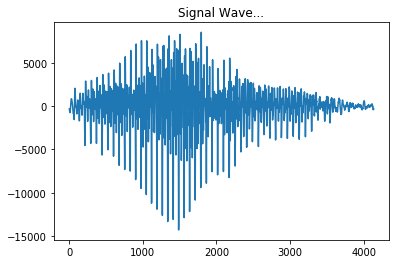

In [8]:
plt.plot(signal)
plt.title('Signal Wave...')

II) Feature Extraction & Model Training
-----------------------

In [3]:
import numpy as np
from sklearn import preprocessing
import python_speech_features as mfcc

In [4]:
#Helper functions to calculate Deltas and Extract Features

def calculate_delta(array):
    """Calculate and returns the delta of given feature vector matrix"""

    rows,cols = array.shape
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:                 
                first = 0             
            else:                 
                first = i-j             
            
            if i+j > rows-1:
                second = rows-1
            else:
                second = i+j 
            
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

def extract_features(audio,rate):
    """extract 20 dim mfcc features from an audio, performs CMS and combines 
    delta to make it 40 dim feature vector"""    
    
    mfcc_feat = mfcc.mfcc(audio,rate, 0.025, 0.01,20,appendEnergy = True)    
    mfcc_feat = preprocessing.scale(mfcc_feat)
    delta = calculate_delta(mfcc_feat)
    combined = np.hstack((mfcc_feat,delta)) 
    return combined

In [5]:
import pickle
import numpy as np
from scipy.io.wavfile import read
from sklearn.mixture import GMM 
import warnings
warnings.filterwarnings("ignore")

#path to training data
source   = "data\\"   

#path where training speakers will be saved
dest = "models\\"
train_file = "training_list.txt"        
file_paths = open(train_file,'r')

count = 1
# Extracting features for each digit data provided by speaker 
features = np.asarray(())
for path in file_paths:    
    path = path.strip()   
    print(path)
    
    # read the audio
    sr,audio = read(source + path)
    
    # extract 40 dimensional MFCC & delta MFCC features
    vector   = extract_features(audio,sr)
    
    if features.size == 0:
        features = vector
    else:
        features = np.vstack((features, vector))
    # when features of training files of each digit for a given speaker are concatenated, model training is done
    if count == 10:    
        gmm = GMM(n_components = 16, n_iter = 200, covariance_type='diag',n_init = 3)
        gmm.fit(features)
        
        # dumping the trained gaussian model
        picklefile = path.split("\\")[0]+".gmm"
        pickle.dump(gmm,open(dest + picklefile,'wb'))
        print('+ modeling completed for speaker:',picklefile," with data point = ",features.shape)    
        features = np.asarray(())
        count = 0
    count = count + 1

Speaker1_digit_1\wav\Speaker1_digit_1_0.wav
Speaker1_digit_1\wav\Speaker1_digit_1_1.wav
Speaker1_digit_1\wav\Speaker1_digit_1_2.wav
Speaker1_digit_1\wav\Speaker1_digit_1_3.wav
Speaker1_digit_1\wav\Speaker1_digit_1_4.wav
Speaker1_digit_1\wav\Speaker1_digit_1_5.wav
Speaker1_digit_1\wav\Speaker1_digit_1_6.wav
Speaker1_digit_1\wav\Speaker1_digit_1_7.wav
Speaker1_digit_1\wav\Speaker1_digit_1_8.wav
Speaker1_digit_1\wav\Speaker1_digit_1_9.wav
+ modeling completed for speaker: Speaker1_digit_1.gmm  with data point =  (519, 40)
Speaker1_digit_2\wav\Speaker1_digit_2_0.wav
Speaker1_digit_2\wav\Speaker1_digit_2_1.wav
Speaker1_digit_2\wav\Speaker1_digit_2_2.wav
Speaker1_digit_2\wav\Speaker1_digit_2_3.wav
Speaker1_digit_2\wav\Speaker1_digit_2_4.wav
Speaker1_digit_2\wav\Speaker1_digit_2_5.wav
Speaker1_digit_2\wav\Speaker1_digit_2_6.wav
Speaker1_digit_2\wav\Speaker1_digit_2_7.wav
Speaker1_digit_2\wav\Speaker1_digit_2_8.wav
Speaker1_digit_2\wav\Speaker1_digit_2_9.wav
+ modeling completed for speaker: S

III) Model Testing
-------------------

In [14]:
import time, os

#path to training data
source   = "data\\"   
models_dir = "models\\"
test_file = "testing_list.txt"        
file_paths = open(test_file,'r')

gmm_files = [os.path.join(models_dir,fname) for fname in os.listdir(models_dir) if fname.endswith('.gmm')]

gmm_files

['models\\Speaker1_digit_1.gmm',
 'models\\Speaker1_digit_2.gmm',
 'models\\Speaker1_digit_3.gmm',
 'models\\Speaker2_digit_1.gmm',
 'models\\Speaker2_digit_2.gmm',
 'models\\Speaker2_digit_3.gmm',
 'models\\Speaker3_digit_1.gmm',
 'models\\Speaker3_digit_2.gmm',
 'models\\Speaker3_digit_3.gmm']

In [15]:
#Load the Gaussian Models
models    = [pickle.load(open(fname,'rb')) for fname in gmm_files]
models

[GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
   n_components=16, n_init=3, n_iter=200, params='wmc', random_state=None,
   tol=0.001, verbose=0),
 GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
   n_components=16, n_init=3, n_iter=200, params='wmc', random_state=None,
   tol=0.001, verbose=0),
 GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
   n_components=16, n_init=3, n_iter=200, params='wmc', random_state=None,
   tol=0.001, verbose=0),
 GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
   n_components=16, n_init=3, n_iter=200, params='wmc', random_state=None,
   tol=0.001, verbose=0),
 GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
   n_components=16, n_init=3, n_iter=200, params='wmc', random_state=None,
   tol=0.001, verbose=0),
 GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
   n_components=16, n_init=3, n_iter=200, params='wmc', random_state=None,
   tol=0.001, verbose=0),
 GMM

In [16]:
speakers_digit   = [fname.split("\\")[-1].split(".gmm")[0] for fname in gmm_files]
speakers_digit

['Speaker1_digit_1',
 'Speaker1_digit_2',
 'Speaker1_digit_3',
 'Speaker2_digit_1',
 'Speaker2_digit_2',
 'Speaker2_digit_3',
 'Speaker3_digit_1',
 'Speaker3_digit_2',
 'Speaker3_digit_3']

In [17]:
# Read the test directory and get the list of test audio files 
path_predicted_dict = dict()

for path in file_paths:   
    
    path = path.strip()   
    print(path)
    sr,audio = read(source + path)
    vector   = extract_features(audio,sr)
    
    log_likelihood = np.zeros(len(models)) 
    
    for i in range(len(models)):
        gmm    = models[i]  #checking with each model one by one
        scores = np.array(gmm.score(vector))
        log_likelihood[i] = scores.sum()
    
    winner = np.argmax(log_likelihood)
    print("\tSpeaker & Digit detected as - ", speakers_digit[winner])
    path_predicted_dict[path] = speakers_digit[winner]

Speaker1_digit_1\wav\Speaker1_digit_1_10.wav
	Speaker & Digit detected as -  Speaker1_digit_1
Speaker1_digit_1\wav\Speaker1_digit_1_11.wav
	Speaker & Digit detected as -  Speaker1_digit_1
Speaker1_digit_1\wav\Speaker1_digit_1_12.wav
	Speaker & Digit detected as -  Speaker1_digit_1
Speaker1_digit_2\wav\Speaker1_digit_2_10.wav
	Speaker & Digit detected as -  Speaker1_digit_2
Speaker1_digit_2\wav\Speaker1_digit_2_11.wav
	Speaker & Digit detected as -  Speaker1_digit_2
Speaker1_digit_2\wav\Speaker1_digit_2_12.wav
	Speaker & Digit detected as -  Speaker1_digit_2
Speaker1_digit_3\wav\Speaker1_digit_3_10.wav
	Speaker & Digit detected as -  Speaker1_digit_3
Speaker1_digit_3\wav\Speaker1_digit_3_11.wav
	Speaker & Digit detected as -  Speaker1_digit_3
Speaker1_digit_3\wav\Speaker1_digit_3_12.wav
	Speaker & Digit detected as -  Speaker1_digit_3
Speaker2_digit_1\wav\Speaker2_digit_1_10.wav
	Speaker & Digit detected as -  Speaker2_digit_1
Speaker2_digit_1\wav\Speaker2_digit_1_11.wav
	Speaker & Digi

In [19]:
correct_pred = 0
incorrect_pred = 0
for i in path_predicted_dict.keys():
    if i.split("\\")[0] == path_predicted_dict[i]:
        correct_pred += 1
    else:
        incorrect_pred += 1

print("Accuracy on Test Dataset = ", correct_pred*100/(correct_pred + incorrect_pred), "%")

Accuracy on Test Dataset =  96.29629629629629 %


<b> Hence, it can be seen how this model effectively predicts the speaker and the corresponding digit he said for the pass code. In acual application this passcode will be a four digit number and the model will also train itself to be more robust with more usage. </b>